### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tabulate import tabulate  # For pretty table formatting

# Set pandas display options for better readability
pd.set_option('display.float_format', '{:.6f}'.format)

# (b) & (c)

### 1: Load & Prepare Data

`Stkcd` is the stock code, `Trdwnt` is the trading week, and `Wretnd` is the weekly stock return.

In [4]:
# Load weekly stock returns from two Excel files and concatenate them
stock_returns1 = pd.read_excel('D:\MG\！CUHKSZ\~！大二 下\FIN3080\Assignments\A3\TRD_Week_1.xlsx', header=0, skiprows=[1, 2], dtype={'Stkcd': str})
stock_returns2 = pd.read_excel('D:\MG\！CUHKSZ\~！大二 下\FIN3080\Assignments\A3\TRD_Week_2.xlsx', header=0, skiprows=[1, 2], dtype={'Stkcd': str})
stock_returns = pd.concat([stock_returns1, stock_returns2], ignore_index=True)

# Load risk-free rate data and format the trading week
rf_data = pd.read_excel('D:\MG\！CUHKSZ\~！大二 下\FIN3080\Assignments\A3\weekly_risk_free_rate.xlsx', sheet_name='Sheet1')
rf_data['trading_date_yw'] = pd.to_datetime(rf_data['trading_date_yw'])
rf_data.set_index('trading_date_yw', inplace=True)
rf_data['Trdwnt'] = rf_data.index.to_period('W').strftime('%Y-%U')

# Merge stock returns with risk-free rates
data = pd.merge(stock_returns, rf_data[['Trdwnt', 'risk_free_return']], on='Trdwnt', how='left')

# Display a sample of the merged data
print("Merged Data Sample:")
print(tabulate(data.head(), headers=['Stkcd', 'Trdwnt', 'Wretnd', 'risk_free_return'], tablefmt='pretty', floatfmt='.6f'))

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
C:\Users\19927\AppData\Local\Temp\ipykernel_45408\3674383000.py:2: SyntaxWarning: invalid escape sequence '\M'
  stock_returns1 = pd.read_excel('D:\MG\！CUHKSZ\~！大二 下\FIN3080\Assignments\A3\TRD_Week_1.xlsx', header=0, skiprows=[1, 2], dtype={'Stkcd': str})
C:\Users\19927\AppData\Local\Temp\ipykernel_45408\3674383000.py:3: SyntaxWarning: invalid escape sequence '\M'
  stock_returns2 = pd.read_excel('D:\MG\！CUHKSZ\~！大二 下\FIN3080\Assignments\A3\TRD_Week_2.xlsx', header=0, skiprows=[1, 2], dtype={'Stkcd': str})
C:\Users\19927\AppData\Local\Temp\ipykernel_45408\3674383000.py:7: SyntaxWarning: invalid escape sequence '\M'
  rf_data = pd.read_excel('D:\MG\！CUHKSZ\~！大二 下\FIN3080\Assignments\A3\weekly

Merged Data Sample:
+---+--------+---------+-----------+-----------------------+
|   | Stkcd  | Trdwnt  |  Wretnd   |   risk_free_return    |
+---+--------+---------+-----------+-----------------------+
| 0 | 000001 | 2017-01 | 0.003297  | 0.0005714053404517472 |
| 1 | 000001 | 2017-02 | 0.003286  | 0.0007376706344075501 |
| 2 | 000001 | 2017-03 |  0.00655  | 0.0005432766629382968 |
| 3 | 000001 | 2017-04 | 0.011931  | 0.0007736414554528892 |
| 4 | 000001 | 2017-05 | -0.007503 | 0.0008020293316803873 |
+---+--------+---------+-----------+-----------------------+


### 2: Calculate Market Returns

In [5]:
# Calculate market return as the mean of weekly returns across all stocks per week
market_returns = data.groupby('Trdwnt')['Wretnd'].mean().reset_index()
market_returns.rename(columns={'Wretnd': 'Market_Return'}, inplace=True)

# Merge market returns back into the main dataset
data = pd.merge(data, market_returns, on='Trdwnt', how='left')

# Display a sample with market returns
print("Data with Market Returns:")
print(tabulate(data.head(), headers=['Stkcd', 'Trdwnt', 'Wretnd', 'risk_free_return', 'Market_Return'], tablefmt='pretty', floatfmt='.6f'))

Data with Market Returns:
+---+--------+---------+-----------+-----------------------+------------------------+
|   | Stkcd  | Trdwnt  |  Wretnd   |   risk_free_return    |     Market_Return      |
+---+--------+---------+-----------+-----------------------+------------------------+
| 0 | 000001 | 2017-01 | 0.003297  | 0.0005714053404517472 |  0.016611333917923535  |
| 1 | 000001 | 2017-02 | 0.003286  | 0.0007376706344075501 |  -0.03504762827225131  |
| 2 | 000001 | 2017-03 |  0.00655  | 0.0005432766629382968 | -0.017416864300626302  |
| 3 | 000001 | 2017-04 | 0.011931  | 0.0007736414554528892 |  0.019901674732111994  |
| 4 | 000001 | 2017-05 | -0.007503 | 0.0008020293316803873 | -0.0025298505029483177 |
+---+--------+---------+-----------+-----------------------+------------------------+


# (d)

### 1: Ensure Only Consistent Stocks

In [6]:
# Filter to include only stocks present in all weeks to ensure data consistency
stocks_per_week = data.groupby('Trdwnt')['Stkcd'].apply(set)
consistent_stocks = set.intersection(*stocks_per_week)
data = data[data['Stkcd'].isin(consistent_stocks)].reset_index(drop=True)

# Report the number of consistent stocks
print(f"Number of Consistent Stocks: {len(consistent_stocks)}")

Number of Consistent Stocks: 1604


### 2: Divide Data into Three Periods

If `total_weeks` isn’t perfectly divisible by 3, the third period may have slightly more or fewer weeks, which is acceptable.

In [5]:
# Divide unique trading weeks into three approximately equal periods
unique_weeks = sorted(data['Trdwnt'].unique())
total_weeks = len(unique_weeks)
period_size = total_weeks // 3

period1_weeks = unique_weeks[:period_size]
period2_weeks = unique_weeks[period_size:2*period_size]
period3_weeks = unique_weeks[2*period_size:]

# Split data into three periods
period1_data = data[data['Trdwnt'].isin(period1_weeks)].copy()
period2_data = data[data['Trdwnt'].isin(period2_weeks)].copy()
period3_data = data[data['Trdwnt'].isin(period3_weeks)].copy()

# Verify the number of weeks in each period
print(f"Period 1 Weeks: {len(period1_weeks)}, Period 2 Weeks: {len(period2_weeks)}, Period 3 Weeks: {len(period3_weeks)}")

Period 1 Weeks: 102, Period 2 Weeks: 102, Period 3 Weeks: 104


### 3: Calculate Individual Stock Betas (First Period)

Use the model $r_{i,t} = \alpha_i + \beta_i r_{m,t} + \epsilon_i$, consistent with Section 4.1.1.

In [6]:
def calculate_stock_beta(group):
    """Calculate stock beta using OLS: r_{i,t} = alpha_i + beta_i * r_{m,t} + epsilon_i"""
    X = sm.add_constant(group['Market_Return'])
    y = group['Wretnd']
    model = sm.OLS(y, X, missing='drop').fit()
    return pd.Series({'beta': model.params['Market_Return']})

# Calculate betas for each stock in the first period
stock_betas = period1_data.groupby('Stkcd').apply(calculate_stock_beta).reset_index()

C:\Users\19927\AppData\Local\Temp\ipykernel_29416\3446040974.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stock_betas = period1_data.groupby('Stkcd').apply(calculate_stock_beta).reset_index()


### 4: Form Ten Portfolios

Portfolios are formed by sorting $\beta_i$ into deciles。

In [7]:
# Assign stocks to 10 portfolios based on beta deciles from the first period
stock_betas['beta_group'] = pd.qcut(stock_betas['beta'], 10, labels=False) + 1

# Merge beta groups into period 2 and 3 data
period2_data = pd.merge(period2_data, stock_betas[['Stkcd', 'beta_group']], on='Stkcd', how='left')
period3_data = pd.merge(period3_data, stock_betas[['Stkcd', 'beta_group']], on='Stkcd', how='left')

# Verify the number of stocks per portfolio
portfolio_counts = period2_data.groupby('beta_group')['Stkcd'].nunique()
print("Number of Stocks in Each Portfolio:")
print(tabulate(portfolio_counts.reset_index(), headers=['Portfolio', 'Stock Count'], tablefmt='pretty'))

Number of Stocks in Each Portfolio:
+---+-----------+-------------+
|   | Portfolio | Stock Count |
+---+-----------+-------------+
| 0 |     1     |     161     |
| 1 |     2     |     160     |
| 2 |     3     |     160     |
| 3 |     4     |     161     |
| 4 |     5     |     160     |
| 5 |     6     |     160     |
| 6 |     7     |     161     |
| 7 |     8     |     160     |
| 8 |     9     |     160     |
| 9 |    10     |     161     |
+---+-----------+-------------+


### 5: Calculate Portfolio Betas (Second Period) - Table 2

- Portfolio returns are equal-weighted averages.
- Regression uses $r_{p,t} - r_{f,t} = \alpha_p + \beta_p (r_{m,t} - r_{f,t}) + \epsilon_{p,t}$.
- Outputs $\alpha_p$, $\beta_p$, t-values, p-values, and $R^2$, matching Table 2’s structure.

In [8]:
# Calculate equal-weighted portfolio returns for the second period
portfolio_returns_p2 = period2_data.groupby(['Trdwnt', 'beta_group'])['Wretnd'].mean().reset_index()
portfolio_data_p2 = pd.merge(portfolio_returns_p2, 
                             period2_data[['Trdwnt', 'Market_Return', 'risk_free_return']].drop_duplicates(), 
                             on='Trdwnt', how='left')

# Compute excess returns
portfolio_data_p2['portfolio_excess'] = portfolio_data_p2['Wretnd'] - portfolio_data_p2['risk_free_return']
portfolio_data_p2['market_excess'] = portfolio_data_p2['Market_Return'] - portfolio_data_p2['risk_free_return']

# Perform time series regression for each portfolio
table2_results = []
for group in range(1, 11):
    group_data = portfolio_data_p2[portfolio_data_p2['beta_group'] == group]
    if len(group_data) < 2:
        continue
    X = sm.add_constant(group_data['market_excess'])
    y = group_data['portfolio_excess']
    model = sm.OLS(y, X, missing='drop').fit()
    table2_results.append({
        'Portfolio': group,
        'Alpha': model.params['const'],
        'Alpha_t': model.tvalues['const'],
        'Alpha_p': model.pvalues['const'],
        'Beta': model.params['market_excess'],
        'Beta_t': model.tvalues['market_excess'],
        'Beta_p': model.pvalues['market_excess'],
        'R_squared': model.rsquared
    })

# Format and display Table 2
table2_df = pd.DataFrame(table2_results)
table2_df['Alpha'] = table2_df['Alpha'].round(6)
table2_df['Alpha_t'] = table2_df['Alpha_t'].round(3)
table2_df['Alpha_p'] = table2_df['Alpha_p'].apply(lambda x: f"{x:.4f}")
table2_df['Beta'] = table2_df['Beta'].round(6)
table2_df['Beta_t'] = table2_df['Beta_t'].round(3)
table2_df['Beta_p'] = table2_df['Beta_p'].apply(lambda x: f"{x:.4e}")
table2_df['R_squared'] = table2_df['R_squared'].round(4)

print("Table 2: Time Series Regression Results for Portfolios")
print(tabulate(table2_df, headers='keys', tablefmt='pretty', showindex=False))

Table 2: Time Series Regression Results for Portfolios
+-----------+----------+---------+---------+----------+--------+------------+-----------+
| Portfolio |  Alpha   | Alpha_t | Alpha_p |   Beta   | Beta_t |   Beta_p   | R_squared |
+-----------+----------+---------+---------+----------+--------+------------+-----------+
|     1     | -3.6e-05 | -0.033  | 0.9738  | 0.673459 | 20.328 | 4.1086e-37 |  0.8067   |
|     2     | 0.000628 |  0.786  | 0.4335  | 0.806966 | 32.951 | 3.6391e-55 |  0.9164   |
|     3     | 0.000533 |  0.743  | 0.4591  | 0.841312 | 38.289 | 3.7288e-61 |  0.9367   |
|     4     | 0.000559 |  0.789  | 0.4318  | 0.892307 | 41.089 | 5.1897e-64 |  0.9446   |
|     5     | 6.8e-05  |  0.116  | 0.9081  | 0.934127 | 52.07  | 9.5865e-74 |  0.9648   |
|     6     | 0.000441 |  0.841  | 0.4024  | 1.011989 | 62.973 | 1.1111e-81 |  0.9756   |
|     7     | 0.000372 |  0.796  | 0.4277  | 1.002425 | 69.98  | 4.0619e-86 |  0.9802   |
|     8     | 0.000385 |  0.722  | 0.4719  | 

### 6: Calculate Average Excess Returns (Third Period)

Computes $\overline{r_{p,t} - r_{f,t}}$ over the third period.

In [ ]:
# Calculate equal-weighted portfolio returns for the third period
portfolio_returns_p3 = period3_data.groupby(['Trdwnt', 'beta_group'])['Wretnd'].mean().reset_index()
portfolio_data_p3 = pd.merge(portfolio_returns_p3, 
                             period3_data[['Trdwnt', 'risk_free_return']].drop_duplicates(), 
                             on='Trdwnt', how='left')

# Compute excess returns
portfolio_data_p3['portfolio_excess'] = portfolio_data_p3['Wretnd'] - portfolio_data_p3['risk_free_return']

# Calculate average excess returns per portfolio
avg_excess_returns = portfolio_data_p3.groupby('beta_group')['portfolio_excess'].mean().reset_index()
avg_excess_returns.rename(columns={'portfolio_excess': 'avg_excess_return'}, inplace=True)

# Display average excess returns
print("Average Excess Returns for Each Portfolio in Period 3:")
print(tabulate(avg_excess_returns, headers=['Portfolio', 'Avg Excess Return'], tablefmt='pretty', floatfmt='.6f'))

Average Excess Returns for Each Portfolio in Period 3:
+---+-----------+-----------------------+
|   | Portfolio |   Avg Excess Return   |
+---+-----------+-----------------------+
| 0 |    1.0    | 0.0011227736376281361 |
| 1 |    2.0    | 0.0009735728673803038 |
| 2 |    3.0    | 0.0004225399465882249 |
| 3 |    4.0    | 0.001097632133415603  |
| 4 |    5.0    | 0.001715878003518918  |
| 5 |    6.0    | 0.0010043155035189177 |
| 6 |    7.0    | 0.0014534650465205781 |
| 7 |    8.0    | 0.001166215255994165  |
| 8 |    9.0    | 0.001558971196588225  |
| 9 |   10.0    | 0.0011130892393746462 |
+---+-----------+-----------------------+


### 7: Cross-Sectional Regression - Table 3

- Regresses $\overline{r_{p,t} - r_{f,t}} = \gamma_0 + \gamma_1 \beta_p + \epsilon_p$.
- Reports coefficients, t-statistics, p-values, $R^2$, and F-statistics, aligning with Table 3.

In [10]:
# Merge average excess returns with portfolio betas from Period 2
cross_section_data = pd.merge(avg_excess_returns, table2_df[['Portfolio', 'Beta']], 
                              left_on='beta_group', right_on='Portfolio', how='left')

# Perform cross-sectional regression: avg_excess_return = gamma_0 + gamma_1 * Beta + epsilon
X = sm.add_constant(cross_section_data['Beta'])
y = cross_section_data['avg_excess_return']
model = sm.OLS(y, X, missing='drop').fit()

# Compile and format regression results
table3_results = {
    'Coefficient': ['gamma_0', 'gamma_1'],
    'Estimate': [model.params['const'], model.params['Beta']],
    't-value': [model.tvalues['const'], model.tvalues['Beta']],
    'p-value': [model.pvalues['const'], model.pvalues['Beta']],
    'R-squared': [model.rsquared, ''],
    'F-statistic': [model.fvalue, ''],
    'F p-value': [model.f_pvalue, '']
}
table3_df = pd.DataFrame(table3_results)
table3_df['Estimate'] = table3_df['Estimate'].round(6)
table3_df['t-value'] = table3_df['t-value'].round(3)
table3_df['p-value'] = table3_df['p-value'].apply(lambda x: f"{x:.4f}")
table3_df['R-squared'] = table3_df['R-squared'].apply(lambda x: f"{x:.4f}" if x != '' else '')
table3_df['F-statistic'] = table3_df['F-statistic'].apply(lambda x: f"{x:.4f}" if x != '' else '')
table3_df['F p-value'] = table3_df['F p-value'].apply(lambda x: f"{x:.4f}" if x != '' else '')

# Display Table 3
print("Table 3: Cross-Sectional Regression Results")
print(tabulate(table3_df, headers='keys', tablefmt='pretty', showindex=False))

Table 3: Cross-Sectional Regression Results
+-------------+----------+---------+---------+-----------+-------------+-----------+
| Coefficient | Estimate | t-value | p-value | R-squared | F-statistic | F p-value |
+-------------+----------+---------+---------+-----------+-------------+-----------+
|   gamma_0   | 0.000367 |  0.496  | 0.6334  |  0.1287   |   1.1813    |  0.3088   |
|   gamma_1   | 0.000835 |  1.087  | 0.3088  |           |             |           |
+-------------+----------+---------+---------+-----------+-------------+-----------+


### 8: Regression Scatter Plot

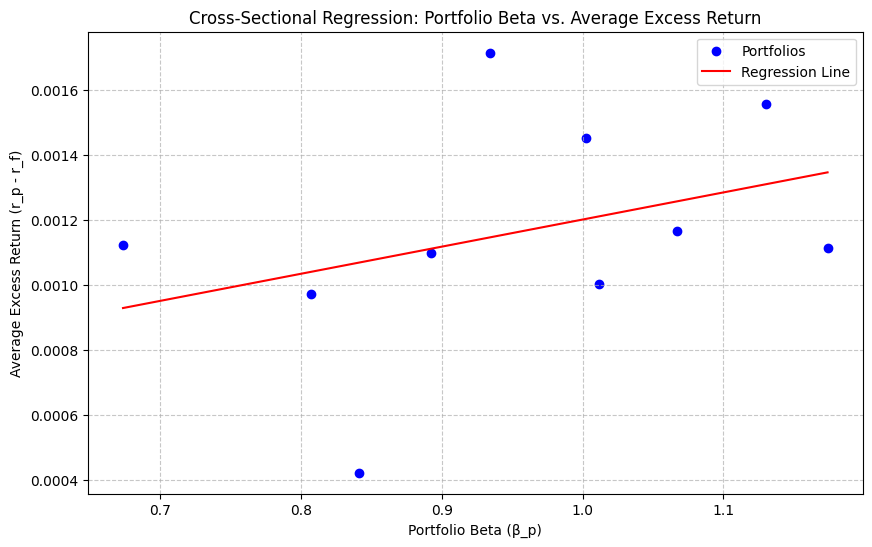

In [11]:
# Create a scatter plot of Beta vs. Average Excess Return
plt.figure(figsize=(10, 6))
plt.scatter(cross_section_data['Beta'], cross_section_data['avg_excess_return'], 
            color='blue', label='Portfolios')

# Add regression line
beta_range = np.linspace(cross_section_data['Beta'].min(), cross_section_data['Beta'].max(), 100)
regression_line = model.params['const'] + model.params['Beta'] * beta_range
plt.plot(beta_range, regression_line, color='red', label='Regression Line')

# Customize plot
plt.xlabel('Portfolio Beta (β_p)')
plt.ylabel('Average Excess Return (r_p - r_f)')
plt.title('Cross-Sectional Regression: Portfolio Beta vs. Average Excess Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Display plot
plt.show()